In [1]:
import sys
sys.path.append('../')

In [2]:
import os
from PIL import Image

In [3]:
import torch
from torch import nn
import torchvision as tv
import numpy as np
import imgaug.augmentables as ia
import imgaug.augmenters as iaa
from numpy import linalg as la
import shapely.affinity as aff
import shapely.geometry as geo
from skimage.draw import polygon

import matplotlib.pyplot as plt

In [4]:
from src.modeling_efficientdet import EfficientDetDoesEAST

In [5]:
image_file = '../../sroie/SROIE2019/0325updated.task1train(626p)/X00016469612.jpg'
annotations_file = image_file.replace('.jpg', '.txt')

In [6]:
pil_image = Image.open(image_file)
np_image = np.array(pil_image)
txt_annotations = open(annotations_file).read().split('\n')

In [7]:
coef = 2
coef2size = {
    0: 512,
    1: 640,
    2: 768,
    3: 896,
    4: 1024,
    5: 1280,
    6: 1280,
    7: 1536
}
size = coef2size[coef]
height = size
width = height // 2

In [8]:
height, width

(768, 384)

In [9]:
width/4, height/4

(96.0, 192.0)

In [10]:
seq = iaa.Sequential([
    iaa.Resize({'width': width, 'height':height})
])

# Creating mask

In [11]:
boxes = []
for row in txt_annotations[:-1]:
    x0, y0, _, _, x2, y2, _, _, _ = row.split(',', 8)
    boxes.append(ia.BoundingBox(int(x0), int(y0), int(x2), int(y2)))
boxes_on_image = ia.BoundingBoxesOnImage(boxes, np_image.shape)

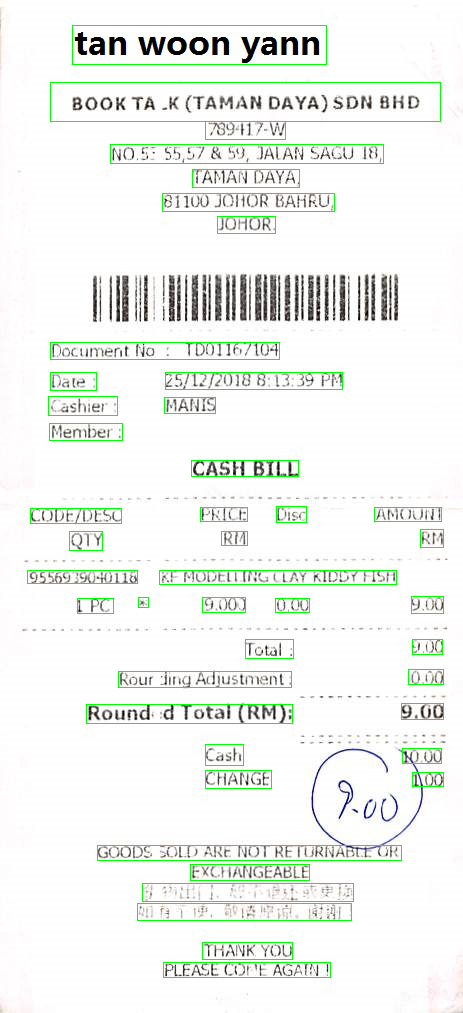

In [12]:
Image.fromarray(boxes_on_image.draw_on_image(np_image))

In [13]:
scale = 4 # 1 for debuggind, change to 4 if not debugin
pct = 0.7
mask_height = height // scale
mask_width  = width // scale
mask_height, mask_width

(192, 96)

In [14]:
image_sz, boxes_sz = iaa.Resize({'width': width, 'height':height})(image=np_image, bounding_boxes=boxes_on_image)
image_sz.shape, boxes_sz.shape

((768, 384, 3), (768, 384, 3))

In [15]:
images_scaled, boxes_scaled = iaa.Resize({'width':mask_width, 'height': mask_height})(image=image_sz, bounding_boxes=boxes_sz)

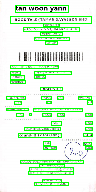

In [16]:
Image.fromarray(boxes_scaled.draw_on_image(images_scaled))

In [17]:
import math

In [18]:
def scale_box(box, pct=0.7, minh=2, minw=4):
    '''
        Parameters:
            - box (np.array or list-like): shape (N, 4) (x1, y1, x2, y2) for each box
            - pct (int): scale factor, (1. - pct) pixels will be removed from each box
            - minh (int): minimum height of the box
            - minw (int): minimum width of the box
    '''
    x1, y1, x2, y2 = box
    height = y2 - y1
    width = x2 - x1
    
    remove_y = math.floor(height - height * (1. - pct))
    remove_x = math.floor(width -  width  * (1. - pct))
        
    center_y = int((y2 + y1) // 2)
    center_x = int((x2 + x1) // 2)
    
    dx = max(minw // 2, math.floor(remove_x / 2))
    dy = max(minh // 2, math.floor(remove_y / 2))
    
    
    x1 = max(x1, center_x - dx)
    x2 = min(x2, center_x + dx)
    y1 = max(y1, center_y - dy)
    y2 = min(y2, center_y + dy)
    return x1, y1, x2, y2

In [19]:
boxes = boxes_scaled.to_xyxy_array(np.int32) # original without removed pixels

In [20]:
mask_boxes = np.array([scale_box(box, pct=0.7) for box in boxes]) # remove pixels from boxes

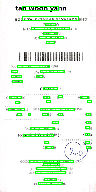

In [21]:
new_bbs = ia.BoundingBoxesOnImage.from_xyxy_array(mask_boxes, shape=(size, size))
Image.fromarray(new_bbs.draw_on_image(images_scaled))

In [22]:
gt_image = np.zeros((5, mask_height, mask_width))
gt_image.shape

(5, 192, 96)

In [23]:
gt_image = np.zeros((5, mask_height, mask_width))
y_loss_mask = np.zeros((1, mask_height, mask_width))

for bbox, mbox in zip(boxes, mask_boxes):
    x1, y1, x2, y2 = mbox.astype(np.int32)
    ox1, oy1, ox2, oy2 = bbox.astype(np.int32)
    
    y_loss_mask[0, oy1:oy2, ox1:ox2] = 1.
    
    for dx in range(x1, x2):
        for dy in range(y1, y2):
#             assert dy - oy1 >= 0 
            gt_image[0, dy, dx] = 1 # score
            gt_image[1, dy, dx] = (dy - oy1) * scale # top
            gt_image[2, dy, dx] = (oy2 - dy) * scale # bottom
            gt_image[3, dy, dx] = (dx - ox1) * scale # left
            gt_image[4, dy, dx] = (ox2 - dx) * scale # right
            
y_loss_mask[0] = 1. * (y_loss_mask[0] == gt_image[0])

In [24]:
gt_image.min(), gt_image.max()

(0.0, 276.0)

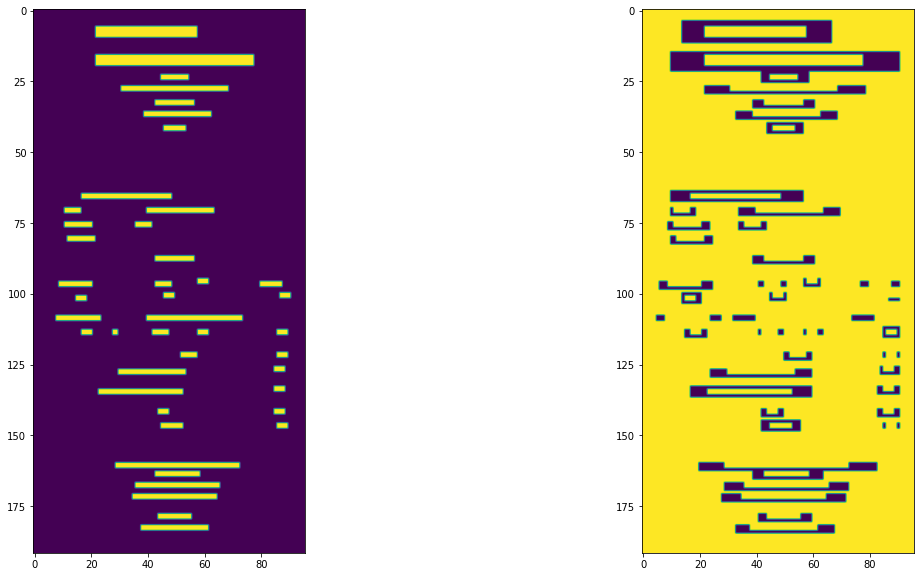

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
# plt.figure(figsize=(10,10))
ax1.imshow(gt_image[0])
ax2.imshow(y_loss_mask[0])

# Model

In [26]:
model = EfficientDetDoesEAST(load_weights=False, compound_coef=0)

In [27]:
model.backbone.init_backbone('../models/efficientdet-d0.pth')

Ignoring Error(s) in loading state_dict for EfficientDetForSemanticSegmentation:
	size mismatch for bifpn.0.conv6_up.depthwise_conv.conv.weight: copying a param with shape torch.Size([64, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 1, 3, 3]).
	size mismatch for bifpn.0.conv6_up.pointwise_conv.conv.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 1, 1]).
	size mismatch for bifpn.0.conv6_up.pointwise_conv.conv.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bifpn.0.conv6_up.bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bifpn.0.conv6_up.bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bifpn.0.conv6_up.bn.running_m

In [28]:
tfms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

In [29]:
torch_image = tfms(image_sz).unsqueeze(0)
torch_image.shape

torch.Size([1, 3, 768, 384])

In [30]:
torch_gt_image = torch.tensor(gt_image).float().unsqueeze(0)
torch_gt_image.shape

torch.Size([1, 5, 192, 96])

In [31]:
torch_loss_mask = torch.tensor(y_loss_mask, dtype=torch.float)
torch_loss_mask.shape

torch.Size([1, 192, 96])

# Loss 

In [32]:
class BalancedBCE(nn.Module):
    
    def forward(self, y_true, y_pred, loss_mask=None):
        bs = y_true.shape[0]
        size = y_true.shape[-1] * y_true.shape[-2]

        y_true = y_true.view(bs, -1)
        y_pred = y_pred.view(bs, -1)

        beta = 1. - y_true.sum(-1, keepdim=True) / size
        first_term = beta * y_true * torch.log(y_pred)
        second_term = (1. - beta) * (1. - y_true) * torch.log(1. - y_pred)
        loss = - first_term - second_term
        
        if loss_mask is not None:
            loss_mask = loss_mask.view(bs, -1)
            loss = loss * loss_mask
            
        return loss.mean()

In [33]:
class IoULoss(nn.Module):

    @staticmethod
    def bbox_loss(y_pred, y_true, y_true_score):
        assert y_true.min() >= 0, y_true.min().item()

        d1_true, d2_true, d3_true, d4_true = torch.split(y_true, 1, 1)
        d1_pred, d2_pred, d3_pred, d4_pred = torch.split(y_pred, 1, 1)
        area_true = (d1_true + d3_true) * (d2_true + d4_true)
        area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
        w_intersect = torch.min(d2_true, d2_pred) + torch.min(d4_true, d4_pred)
        h_intersect = torch.min(d1_true, d1_pred) + torch.min(d3_true, d3_pred)
        area_intersect = w_intersect * h_intersect
        area_union = area_true + area_pred - area_intersect
        aabb_loss = -torch.log((area_intersect + 1.0)/(area_union + 1.0))
        cbox_loss = torch.sum(aabb_loss * y_true_score) / y_true_score.sum()
        return cbox_loss
    
    def forward(self, y_pred, y_true, y_true_score):
        return self.bbox_loss(y_pred, y_true, y_true_score)

In [34]:
class EASTLoss(nn.Module):
    
    def __init__(self, lamb=1.):
        super().__init__()
        self.lamb = lamb
        self.bce = BalancedBCE()
        self.iou = IoULoss()
        
    def forward(self, y_true, y_pred, loss_mask=None):
        bce = self.bce(y_true[:,0] , y_pred[:,0], loss_mask)
        iou = self.iou(y_pred[:,1:], y_true[:,1:], y_true[:,0])
        return bce + self.lamb * iou

In [35]:
east_loss = EASTLoss()

# Overfit

In [36]:
device = 'cuda'

In [37]:
model = model.to(device)

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [39]:
# model.backbone.freeze_bn()

In [271]:
for _ in range(100):
    
    output = model(torch_image.to(device))
    loss = east_loss(torch_gt_image.to(device), output, )#torch_loss_mask.to(device))
    loss.backward()
    optimizer.step()
    
    model.zero_grad()
    
    print(loss.item())

0.15967100858688354
0.17738193273544312
0.1560908854007721
0.3710149824619293
0.22747451066970825
0.2016778141260147
0.18030259013175964
0.21353544294834137
0.15814046561717987
0.16324728727340698
0.18176761269569397
0.16263888776302338
0.16049742698669434
0.1657564640045166
0.12694264948368073
0.15527617931365967
0.1803143173456192
0.1439465880393982
0.1477065533399582
0.15802618861198425
0.15740342438220978
0.1461750864982605
0.13771292567253113
0.135338693857193
0.13559433817863464
0.1386284977197647
0.14834296703338623
0.1333664059638977
0.20109908282756805
0.12546691298484802
0.11817708611488342
0.1154489815235138
0.14421579241752625
0.1222306564450264
0.11493547260761261
0.12033934891223907
0.13955089449882507
0.15223848819732666
0.13930490612983704
0.1188136637210846
0.13044492900371552
0.1169998049736023
0.11443156003952026
0.11014050245285034
0.1016254648566246
0.10811511427164078
0.09736284613609314
0.1186182051897049
0.11362513899803162
0.2769433856010437
0.13193970918655396

In [272]:
output = output.detach().cpu()
score_map = (output[0,0] > 0.9).float()
score_map.min(), score_map.max()

(tensor(0.), tensor(1.))

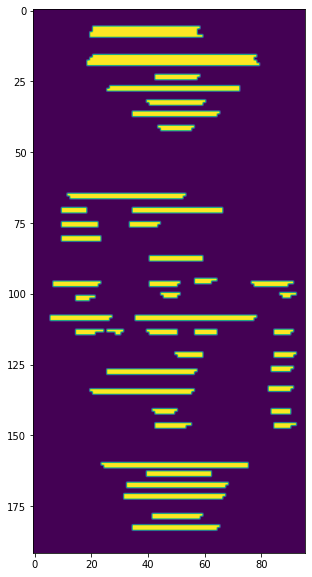

In [273]:
plt.figure(figsize=(10,10))
plt.imshow(score_map)

# NMS

In [274]:
pred_image = output[0]

In [275]:
def decode_v1(pred_image, threshold=0.6, ss=4):
    probas = []
    polys = []
    nz_coords = torch.nonzero(pred_image[0] > threshold)
    for t in zip(nz_coords):
        y, x = t[0]
        proba = pred_image[0, y, x]
        probas.append(proba)
        d1, d2, d3, d4 = pred_image[1:5, y, x]
        box = [ss * x - d3, ss * y - d1,
               ss * x + d4, ss * y + d2]
        polys.append(box)
    return torch.tensor(probas), torch.tensor(polys)

In [276]:
probs, boxes = decode_v1(pred_image, 0.6)

In [277]:
keep_indices = tv.ops.nms(boxes, probs, 0.01)
keep_boxes = boxes[keep_indices]

In [278]:
keep_boxes.shape

torch.Size([46, 4])

In [279]:
keep_boxes_on_image = ia.BoundingBoxesOnImage.from_xyxy_array(keep_boxes, shape=(size, size))

In [280]:
image_sz.shape

(768, 384, 3)

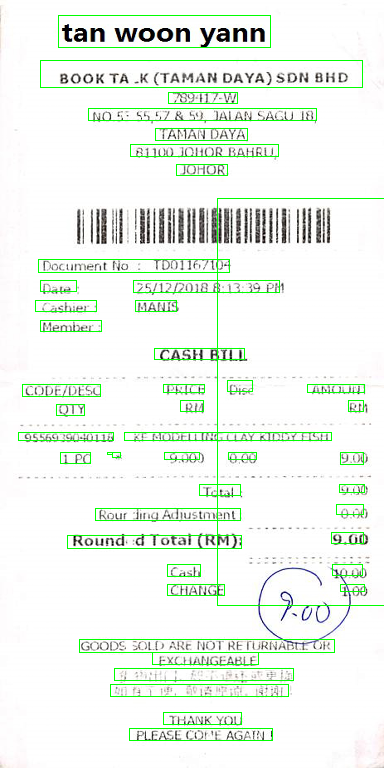

In [281]:
Image.fromarray(keep_boxes_on_image.draw_on_image(image_sz))

# Locality aware NMS

In [152]:
import lanms

In [234]:
probs, boxes = decode_v1(pred_image, 0.6)

In [235]:
ia_boxes = ia.BoundingBoxesOnImage.from_xyxy_array(boxes, image_sz.shape)

In [236]:
ia_polys = ia_boxes.to_polygons_on_image()

In [237]:
ipolys = ia_polys.to_xy_array().reshape(-1, 8) 

In [238]:
reorder_ipolys = ipolys#[:,(6,7,4,5,2,3,0,1)]

In [239]:
polys_n_probs = np.concatenate((reorder_ipolys, probs.unsqueeze(1).numpy()), axis=1)

In [240]:
polys_n_probs.shape

(2755, 9)

In [249]:
new_keep_boxes = lanms.merge_quadrangle_n9(polys_n_probs, 0.1)

In [250]:
new_keep_boxes.shape

(48, 9)

In [251]:
new_ia_boxes = ia.BoundingBoxesOnImage.from_xyxy_array(new_keep_boxes[:,[0,1,4,5]], image_sz.shape)

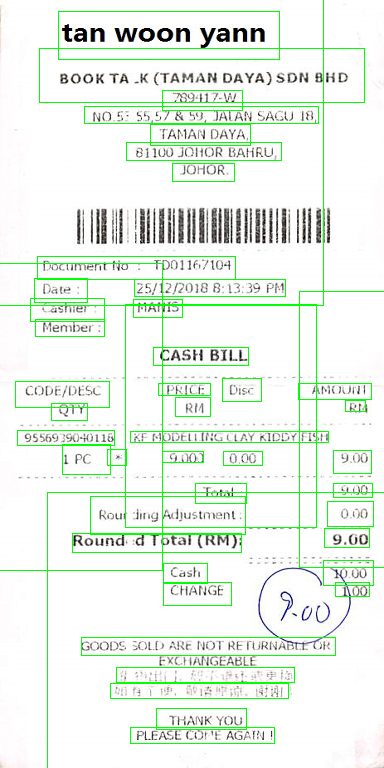

In [252]:
Image.fromarray(new_ia_boxes.draw_on_image(image_sz))

In [ ]:
Polygon()